In [70]:
import numpy as np
import healpy as hp

from scipy.integrate import quad, nquad
from scipy.special import legendre
from scipy.stats import norm
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib
import imageio.v3 as iio

# Use TeX
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 15})

In [2]:
# path to figures in the paper

# On my laptop
path = '/Users/pfleury/Library/CloudStorage/Dropbox/Project - Sparsity covariance/article/figures/'

# On my work station
#path = '/Users/pierrefleury/Library/CloudStorage/Dropbox/Project - Sparsity covariance/article/figures/'

# Contents<a class="anchor" id="contents"></a>
1. [Sparsity covariance toy example](#toy_example)
    1. [Statistical model](#model)
    1. [Generate maps](#generate_maps)
    1. [Estimate correlation from random sample](#estimator)
    1. [Testing the formula for sparsity covariance](#testing_formula)
1. [Estimating $\xi_+(0)$ for shear](#sigma_shear)
    1. [Compute $C_\ell^\gamma$ with CAMB](#C_ell)
    1. [Variance of shear](#sigma_gamma)
    1. [Fitting function](#fitting_function)
    1. [Application to KiDS1000](#KiDS1000)

# 1. Sparsity covariance toy example<a class="anchor" id="toy_example"></a>
[Back to contents](#contents)

## 1.A Statistical model<a class="anchor" id="model"></a>
[Back to contents](#contents)

### Correlation function

In [8]:
# take a correlation scale of 20 degrees for visibility
scale = 20*np.pi/180

def xi_model(theta, amp=1, scale=scale):
    """
    Take an exponential correlation function
    with amplitude 'amp'
    and angular scale 'scale'
    """

    xi = amp * np.exp(- theta / scale)

    return xi

### Harmonic coefficients

In [9]:
def generate_cls(lmax=200, correlation=xi_model):
    
    """
    This is to convert the correlation function into
    an angular power spectrum.
    """

    cls = []
    
    for l in range(lmax):
        P = legendre(l)
        #integrand = lambda th: xi_model(th) * np.sin(th) * P(np.cos(th))
        #cl, err = quad(integrand, 0, np.pi)
        integrand = lambda mu: 2 * np.pi * correlation(np.arccos(mu)) * P(mu)
        cl, err = quad(integrand, -1, 1)
        cls.append(cl)

    return np.array(cls)

/Users/pfleury/anaconda3/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/pfleury/anaconda3/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2479: RuntimeWarning: overflow encountered in scalar power
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/Users/pfleury/anaconda3/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2479: RuntimeWarning: invalid value encountered in scalar divide
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/var/folders/pp/t8q3hnyx3ll7kcn8h_02ghfw0000gp/T/ipykernel_20217/1660101408.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitt

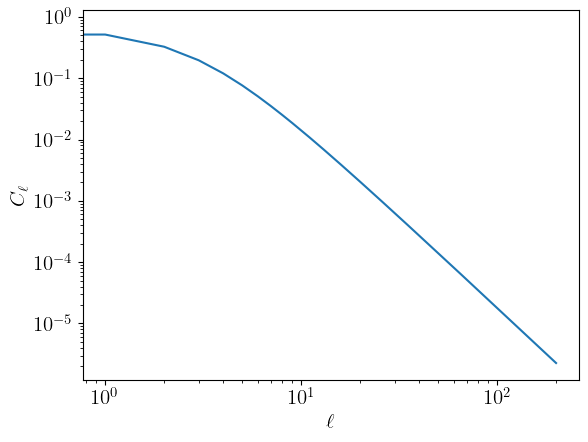

In [10]:
lmax = 200
cls = generate_cls(lmax)
plt.loglog(np.arange(lmax), cls)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.show()

## 1.B Generate maps<a class="anchor" id="generate_maps"></a>
[Back to contents](#contents)

In [11]:
M = 3 # number of maps
nside = 2**12 # resolution of the maps

In [12]:
maps = [hp.sphtfunc.synfast(cls, nside=nside, pol=False) for _ in range(M)]

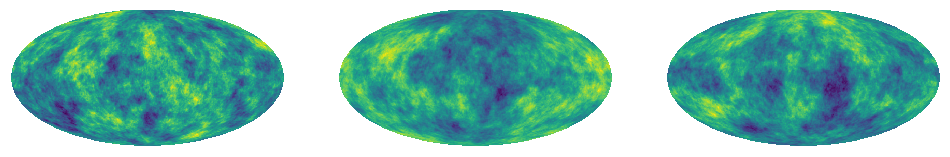

In [13]:
fig, axes = plt.subplots(ncols=M, figsize=(12, 4))

for i, ax in enumerate(axes):
    plt.axes(ax)
    hp.mollview(maps[i], title='', cbar=False, hold=True)

In [11]:
def get_xi_from_map(fmap, lmax=200, thetamin=0, thetamax=np.pi, Ntheta=100):
    """
    This function computes the correlation function from a map
    corresponding to a realisation of the field f on the sphere.
    lmax is the maximum l where Cls are evaluated.
    Ntheta is the number of points where we want it to be evaluated
    between thetamin and thetamax.
    """

    # Compute the Cls of the realisation
    
    cl_real = hp.sphtfunc.anafast(fmap, lmax=lmax, pol=False)
    cl_real = cl_real[:-1] # the last element is the error(?)
    ls = np.arange(lmax)

    
    # Compute the correlation function from the Cls
    
    def get_xi_from_cls(theta):
        mu = np.cos(theta)
        Pls = np.array([legendre(l)(mu) for l in ls])
        xi = np.dot((2*ls + 1) * Pls, cl_real) / 4 / np.pi
        return xi
        
    thetas = np.linspace(thetamin, thetamax, Ntheta)
    xis = np.array([get_xi_from_cls(theta) for theta in thetas])

    return thetas, xis

In [15]:
correlation_functions = [get_xi_from_map(the_map) for the_map in maps]

/Users/pfleury/anaconda3/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/pfleury/anaconda3/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2479: RuntimeWarning: overflow encountered in scalar power
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/Users/pfleury/anaconda3/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2479: RuntimeWarning: invalid value encountered in scalar divide
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


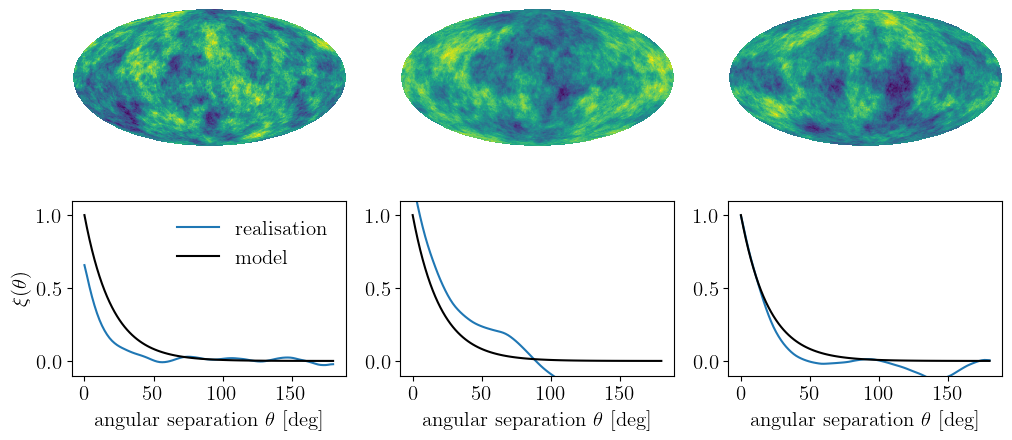

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))

for i in range(M):

    ax = axes[0, i]
    plt.axes(ax)
    hp.mollview(maps[i], title='', cbar=False, hold=True)

    ax = axes[1, i]
    thetas, xis = correlation_functions[i]
    xi_th = xi_model(thetas)
    theta_deg = thetas * 180/np.pi # convert to degrees
    ax.plot(theta_deg, xis, label='realisation')
    ax.plot(theta_deg, xi_th, 'k', label='model')
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel(r'angular separation $\theta$ [deg]')
    if i==0:
        ax.set_ylabel(r'$\xi(\theta)$')
        ax.legend(frameon=False)

## 1.C Estimate correlation from random sample<a class="anchor" id="estimator"></a>
[Back to contents](#contents)

In [17]:
S = 4 # number of samples
N = 500 # number of points in each sample

In [13]:
def generate_random_sample(N):
    
    mus = np.random.uniform(-1, 1, N)
    thetas = np.arccos(mus)
    phis = np.random.uniform(-np.pi, np.pi, N)

    return(thetas, phis)

In [12]:
samples = [generate_random_sample(N) for _ in range(S)]

NameError: name 'S' is not defined

In [14]:
def angular_separation(theta1, phi1, theta2, phi2):

    # cosine of the angle between (theta1, phi1) and (theta2, phi2)
    c12 = (np.sin(theta1) * np.sin(theta2) * np.cos(phi1 - phi2)
           + np.cos(theta1) * np.cos(theta2))
    
    # correct for problematic values due to numerical errors
    c12[c12>1] = 1
    c12[c12<-1] = -1

    theta12 = np.arccos(c12)
    
    return theta12

In [18]:
def estimate_correlation(fmap, sample, thetamax=np.pi, number_bins=25, nside=nside):
    """
    Estimates the (binned) correlation function from a map and a sample of
    directions.
    """
    
    N = len(sample)
    thetas, phis = sample
    
    # displace the points at pixel positions and compute the associated values of the field
    pixels = hp.pixelfunc.ang2pix(nside=nside, theta=thetas, phi=phis)
    field_values = fmap[pixels]
    thetas, phis = hp.pixelfunc.pix2ang(nside=nside, ipix=pixels)
    
    # make a matrix of the form theta_ij, the angle between i and j
    theta1, theta2 = np.meshgrid(thetas, thetas)
    phi1, phi2 = np.meshgrid(phis, phis)
    theta12 = angular_separation(theta1, phi1, theta2, phi2)
    
    # make the matrix of products of field values
    f1, f2 = np.meshgrid(field_values, field_values)
    f1f2 = f1 * f2
    
    # make dtyped array out of those, to allow sorting
    data = np.stack((theta12.flatten(), f1f2.flatten()), axis=-1)
    data = [(elt[0], elt[1]) for elt in data]
    #data = list(map(tuple, data)) # this is slower
    dtype = [('theta12', float), ('f1f2', float)]
    data = np.array(data, dtype=dtype)
    
    # sort the array by increasing angular separation
    data.sort(order='theta12')
    
    # remove the pairs of identical points
    data = data[N:]
    # remove the double counting by selecting even indices
    data = data[::2]
    
    # convert it back into a table
    data = np.array([list(elt) for elt in data])

    # divide the data into equally populated bins (on average)
    # cos(sep) is uniformly distributed
    mumin = np.cos(thetamax)
    limits_mu = np.linspace(1.0, mumin, number_bins+1)
    limits_theta = np.arccos(limits_mu)

    data_binned = []
    i = 0
    
    for b in range(number_bins):
        
        thebin = []
        
        while i < len(data) and data[i, 0] < limits_theta[b+1]:
            thebin.append(data[i])
            i += 1

        data_binned.append(thebin)

    #data_binned = np.array(data_binned)
    
    #data_binned = [data[limits_theta[b]<=data[:, 0]<limits_theta[b+1]] for b in range(number_bins)]
    
    # divide the data into equally populated bins
    #P = pairs_per_bin
    #Ptot = len(data) # total number of pairs
    #B = int(Ptot / P) + 1 # number of bins
    #data_binned = [data[b*P:min((b+1)*P, Ptot)] for b in range(B)]
    
    # average over each bin
    data_mean = np.array([np.mean(b, axis=0) for b in data_binned])
    theta12_mean = data_mean[:, 0]
    xi = data_mean[:, 1]

    return theta12_mean, xi

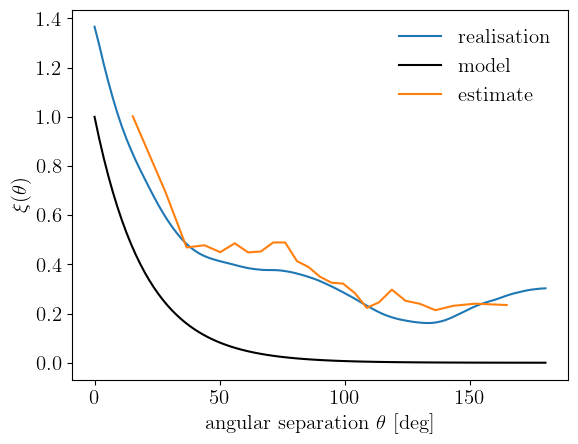

In [21]:
# testing the whole procedure

fmap = hp.sphtfunc.synfast(cls, nside=nside, pol=False)
seps, xis_real = get_xi_from_map(fmap)
xis_th = xi_model(seps)
seps_deg = seps * 180/np.pi
plt.plot(seps_deg, xis_real, label='realisation')
plt.plot(seps_deg, xis_th, 'k', label='model')

sample = generate_random_sample(500)
seps, xis = estimate_correlation(fmap, sample, number_bins=25)
seps_deg = seps * 180/np.pi
plt.plot(seps_deg, xis, label='estimate')

plt.xlabel(r'angular separation $\theta$ [deg]')
plt.ylabel(r'$\xi(\theta)$')
plt.legend(frameon=False)
plt.show()

In [22]:
correlation_functions_estimated = []

for fmap in maps:
    row = []
    for sample in samples:
        elt = estimate_correlation(fmap, sample, number_bins=25)
        row.append(elt)
    correlation_functions_estimated.append(row)

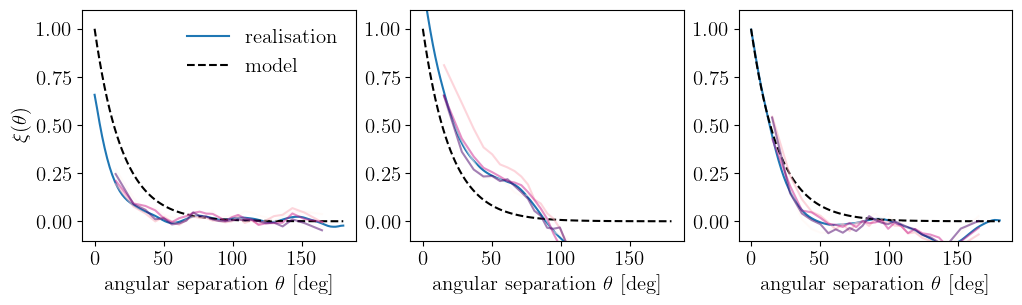

In [23]:
# Plot the correlation functions

fig, axes = plt.subplots(1, M, figsize=(12, 3))

for m in range(M):

    ax = axes[m]
    seps, xis_real = correlation_functions[m]
    xis_th = xi_model(seps)
    seps_deg = seps * 180/np.pi # convert to degrees
    ax.plot(seps_deg, xis_real, label='realisation')
    ax.plot(seps_deg, xis_th, 'k--', label='model')
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel(r'angular separation $\theta$ [deg]')
    if m==0:
        ax.set_ylabel(r'$\xi(\theta)$')
        ax.legend(frameon=False)

    for s in range(S):
        #color = matplotlib.colormaps['autumn'](s/(S-1)*0.5)
        color = matplotlib.colormaps['RdPu'](s/(S-1))
        seps, xis_estimated = correlation_functions_estimated[m][s]
        seps_deg = seps * 180/np.pi
        ax.plot(seps_deg, xis_estimated, alpha=0.5, color=color) # add label

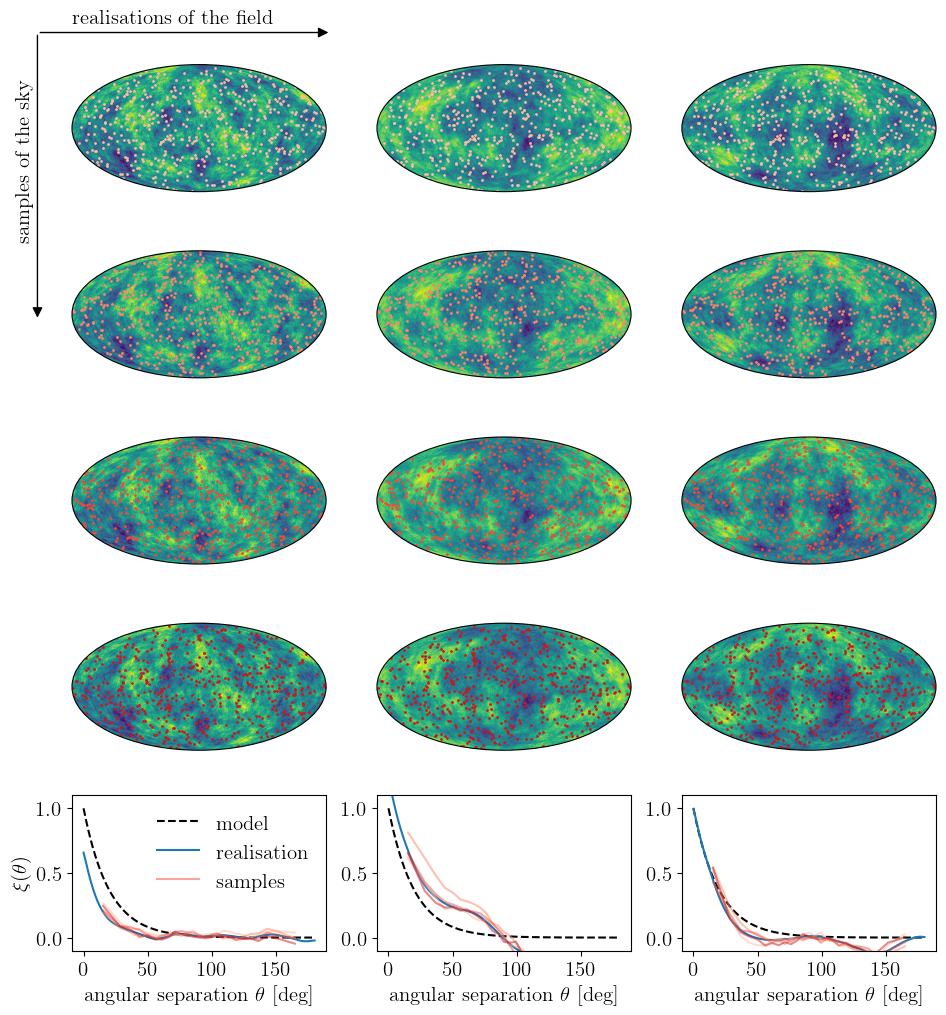

In [24]:
fig = plt.figure(figsize=(9, 10))

# each column is associated with a map m
# each row is associated with a sample s

#coulours_sample = [matplotlib.colormaps['autumn'](s/(S-1)*0.5) for s in range(S)]
#coulours_sample = [matplotlib.colormaps['Oranges'](0.25 + 0.5*s/(S-1)) for s in range(S)]
#coulours_sample = [matplotlib.colormaps['RdPu'](s/(S-1)) for s in range(S)]
coulours_sample = [matplotlib.colormaps['Reds'](0.25 + 0.5*s/(S-1)) for s in range(S)]

for i in range(M): # run over maps

    # define the map
    fmap = maps[i]
    
    for j in range(S): # run over samples

        thetas, phis = samples[j]

        # display maps and samples
        #sub = int(str(S+1) + str(M) + str(S*j + i + 1))
        sub = (S+1, M, M*j+i+1)
        hp.newvisufunc.projview(fmap, title='', cbar=False, sub=sub)
        plt.scatter(phis, np.pi/2-thetas, color=coulours_sample[j], s=1)
        
    # Last row: add the correlation functions

    # first the model and the realisation
    ax = fig.add_subplot(S+1, M, S*M+i+1)
    seps, xis_real = correlation_functions[i]
    xis_th = xi_model(seps)
    seps_deg = seps * 180/np.pi # convert to degrees
    ax.plot(seps_deg, xis_th, 'k--', label='model')
    ax.plot(seps_deg, xis_real, label='realisation')
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel(r'angular separation $\theta$ [deg]')

    # then the various estimates from samples
    for j in range(S):
        seps, xis_estimated = correlation_functions_estimated[i][j]
        seps_deg = seps * 180/np.pi
        if j==2:
            ax.plot(seps_deg, xis_estimated, color=coulours_sample[j], alpha=0.5, label='samples')
        else:
            ax.plot(seps_deg, xis_estimated, color=coulours_sample[j], alpha=0.5)

    # and finally the legend
    if i==0:
        ax.set_ylabel(r'$\xi(\theta)$')
        ax.legend(frameon=False)

# Finally add some annotations
ax = fig.add_subplot(1,1,1, facecolor="none")
ax.axis('off')
x0, y0 = -0.04, 1.02
ax.annotate('', xy=(x0, y0), xycoords='axes fraction', xytext=(0.3, y0), 
            arrowprops=dict(arrowstyle="<|-", color='black'))
ax.text(0, 1.03, r'realisations of the field')
ax.annotate('', xy=(x0, y0), xycoords='axes fraction', xytext=(x0, 0.7), 
            arrowprops=dict(arrowstyle="<|-", color='black'))
ax.text(x0-0.027, 0.79, r'samples of the sky', rotation=90)

#plt.savefig(path+'sparsity_covariance_illustration.png', dpi=300, bbox_inches='tight')
plt.show();

#plt.tight_layout();

### Make a GIF for talks

In [ ]:
# Generate a realisation of the field and its correlation function

fmap = hp.sphtfunc.synfast(cls, nside=2**12, pol=False)
seps, xis_real = get_xi_from_map(fmap)
seps_deg = 180*seps/np.pi
xis_th = xi_model(seps)

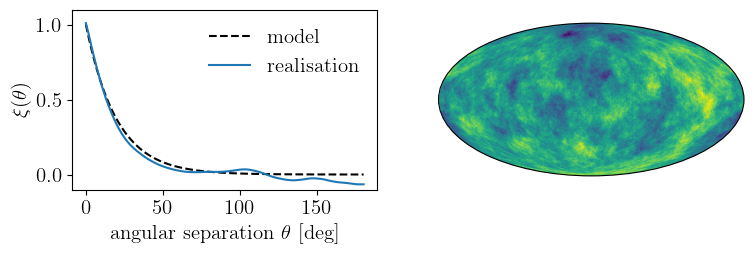

In [88]:
# Make a plot with the map and the correlation function only

fig = plt.figure(figsize=(7, 2))
    
# Mollweide view of the field realisation
sub = (1, 2, 2)
hp.newvisufunc.projview(fmap, title='', cbar=False, sub=sub)

# corresponding correlation function
ax = fig.add_subplot(1, 2, 1)
ax.plot(seps_deg, xis_th, 'k--', label='model')
ax.plot(seps_deg, xis_real, label='realisation')
#ax.plot(seps_sample_deg, xis, 'r', label='sample')
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel(r'angular separation $\theta$ [deg]')
ax.set_ylabel(r'$\xi(\theta)$')
ax.legend(frameon=False)

plt.savefig('figures/map_xi.png',
            format='png',
            dpi=500,
            transparent=False,
            bbox_inches='tight');

In [77]:
# Generate S samples

S = 20
samples_with_xi = []

for _ in range(S):
    sample = generate_random_sample(500)
    seps_sample, xis = estimate_correlation(fmap, sample, number_bins=25)
    seps_sample_deg = seps_sample * 180 / np.pi
    sample_with_xi = (sample, seps_sample_deg, xis)
    samples_with_xi.append(sample_with_xi)

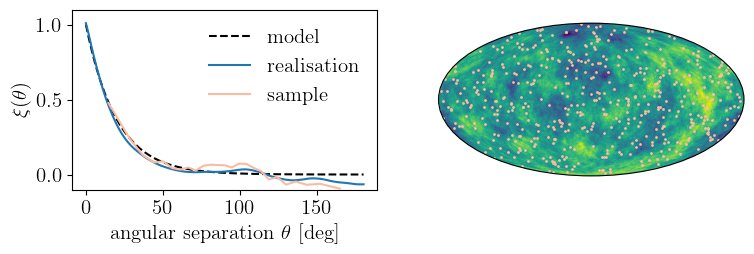

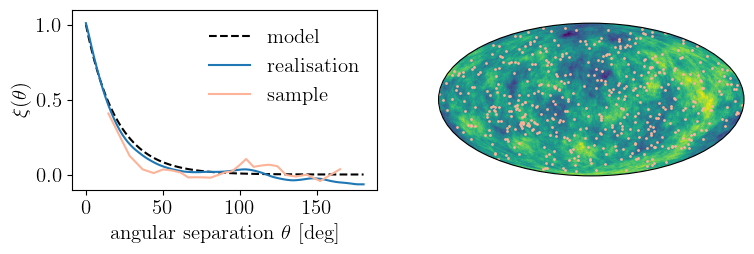

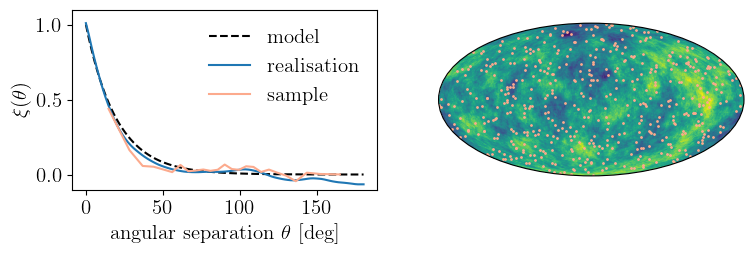

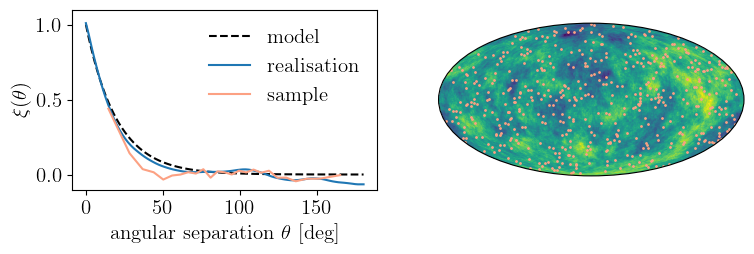

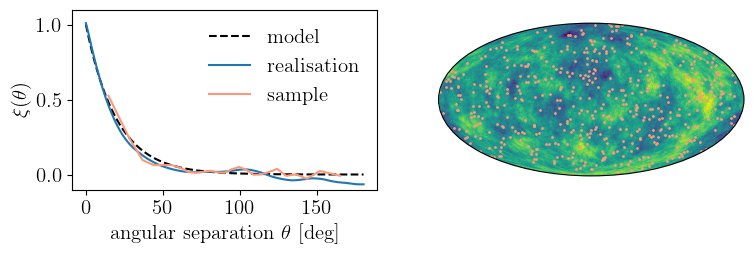

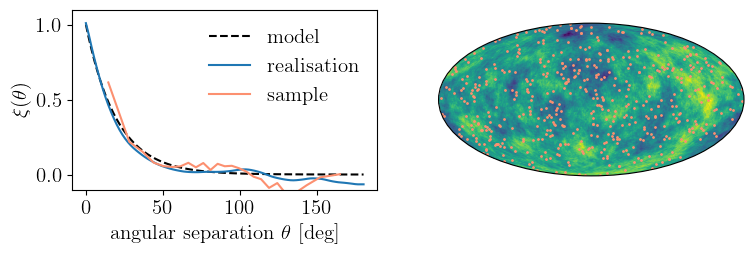

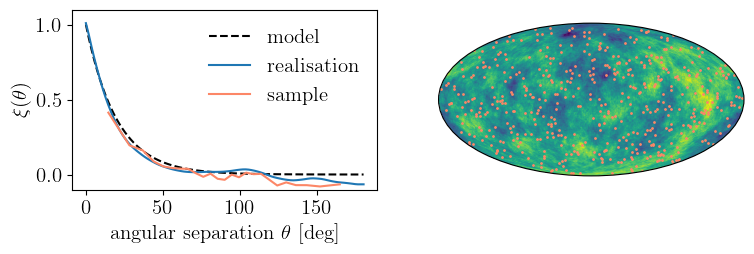

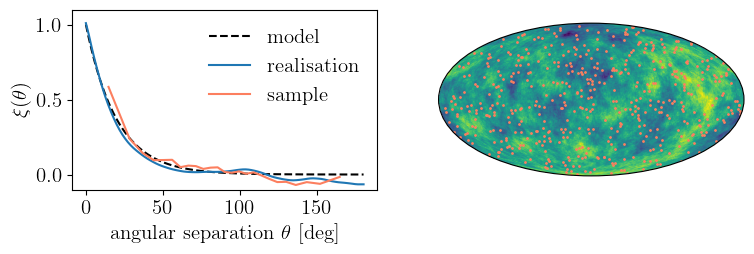

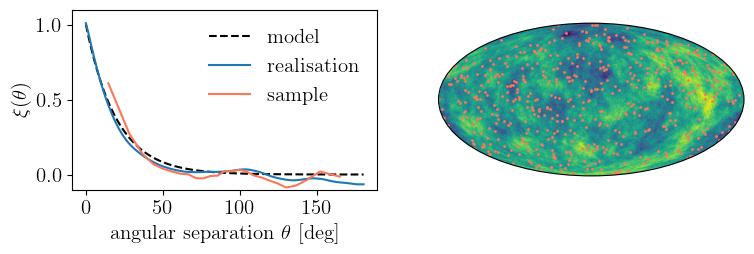

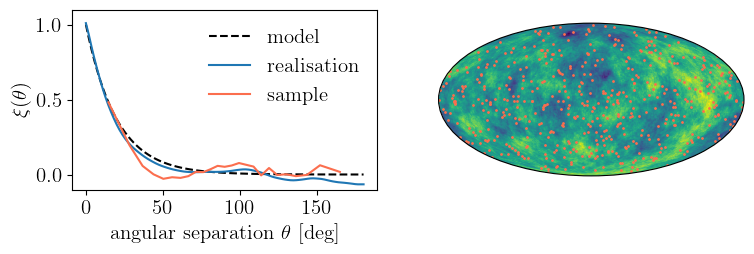

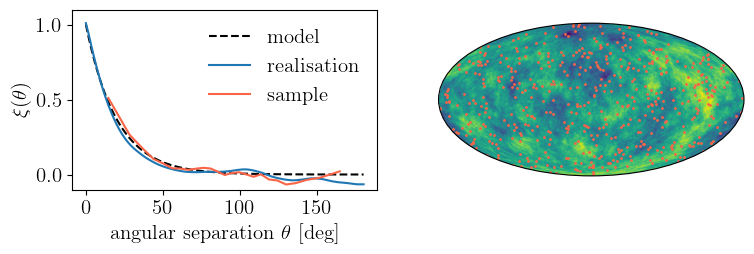

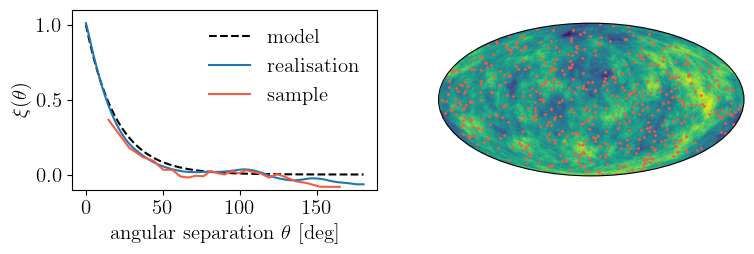

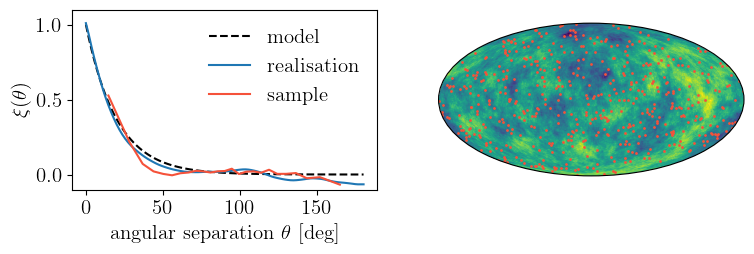

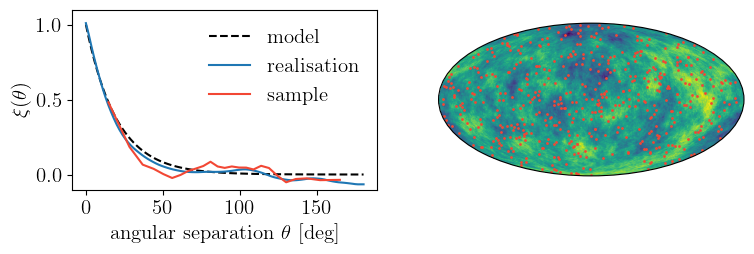

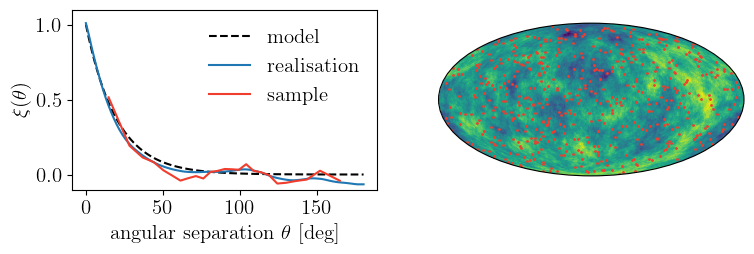

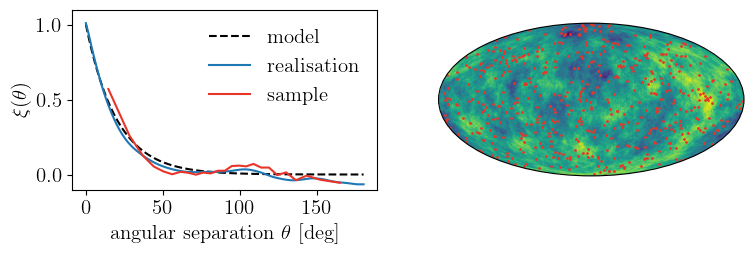

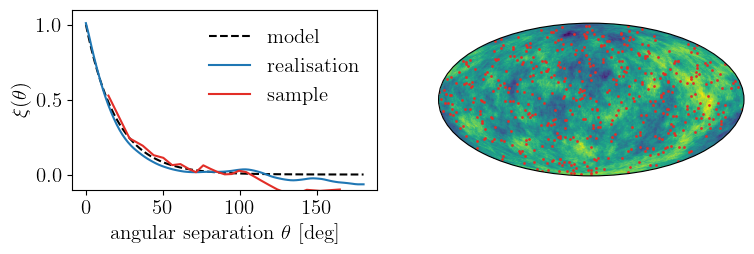

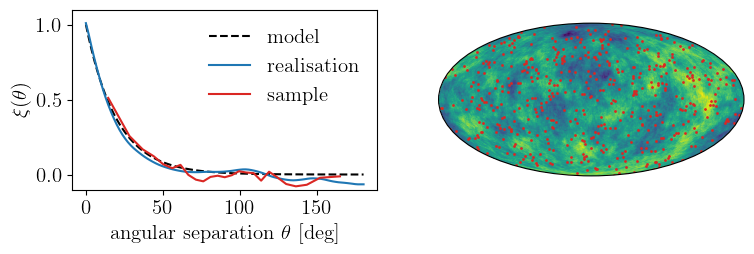

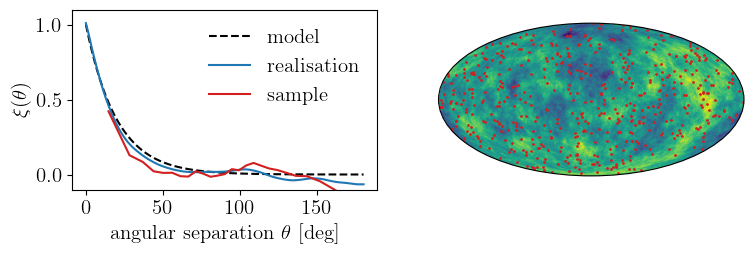

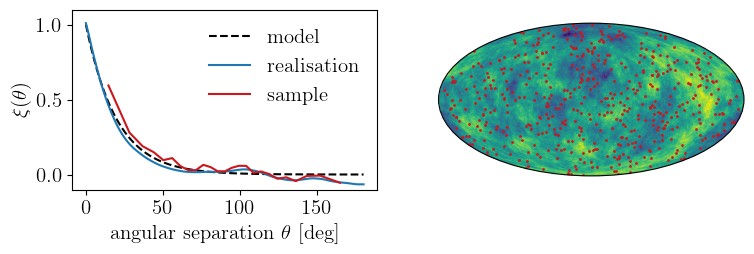

In [78]:
# Make the plots

coulours_sample = [matplotlib.colormaps['Reds'](0.25 + 0.5*s/(S-1)) for s in range(S)]

for s, sample_with_xi in enumerate(samples_with_xi):
    
    sample, seps_sample_deg, xis = sample_with_xi
    colour = coulours_sample[s]
    
    fig = plt.figure(figsize=(7, 2))
    
    # scatter plot of the positions
    thetas, phis = sample
    sub = (1, 2, 2)
    hp.newvisufunc.projview(fmap, title='', cbar=False, sub=sub)
    plt.scatter(phis, np.pi/2-thetas, color=colour, s=1)

    # corresponding correlation function
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(seps_deg, xis_th, 'k--', label='model')
    ax.plot(seps_deg, xis_real, label='realisation')
    ax.plot(seps_sample_deg, xis, color=colour, label='sample')
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel(r'angular separation $\theta$ [deg]')
    ax.set_ylabel(r'$\xi(\theta)$')
    ax.legend(frameon=False)
    
    plt.savefig('figures/animation/sample_{}.png'.format(s),
                format='png',
                dpi=500,
                transparent=False,
                bbox_inches='tight');

In [79]:
# create a gif

frames = np.stack([iio.imread(f"figures/animation/sample_{s}.png") for s in range(S)],
                  axis=0)
iio.imwrite('figures/animation/sparsity_covariance.gif', frames, duration=500)

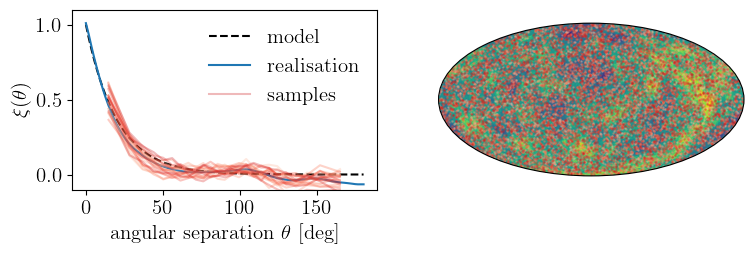

In [87]:
# Plot all the samples altogether

fig = plt.figure(figsize=(7, 2))
    
    
# Mollweide view of the field and samples

sub = (1, 2, 2)
hp.newvisufunc.projview(fmap, title='', cbar=False, sub=sub)

# add the samples
for s, sample_with_xi in enumerate(samples_with_xi):
    colour = coulours_sample[s]
    sample, seps_sample_deg, xis = sample_with_xi
    thetas, phis = sample
    plt.scatter(phis, np.pi/2-thetas, color=colour, alpha=0.3, s=1)

    
# Correlation functions

ax = fig.add_subplot(1, 2, 1)
ax.plot(seps_deg, xis_th, 'k--', label='model')
ax.plot(seps_deg, xis_real, label='realisation')


# add the samples
for s, sample_with_xi in enumerate(samples_with_xi):
    
    sample, seps_sample_deg, xis = sample_with_xi
    colour = coulours_sample[s]
    if s==S-1:
        ax.plot(seps_sample_deg, xis, color=colour, alpha=0.3, label='samples')
    else:
        ax.plot(seps_sample_deg, xis, color=colour, alpha=0.3)
    
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel(r'angular separation $\theta$ [deg]')
ax.set_ylabel(r'$\xi(\theta)$')
ax.legend(frameon=False)
    
plt.savefig('figures/map_xi_with samples.png',
            format='png',
            dpi=500,
            transparent=False,
            bbox_inches='tight');

## 1.D Testing the formula for sparsity covariance<a class="anchor" id="testing_formula"></a>
[Back to contents](#contents)

### Numerical estimate

In [21]:
def estimate_covariance(M=100, S=100, N=500, number_bins=25, nside=2**12):
    """
    Estimates the covariance matrix of the estimator of the correlation function
    by drawing realisations.
    M: number of maps (realisations of the field)
    N: number of directions in each sample
    S: number of samples per map
    """

    # First step: compute the discrepancy between the xi generated for each sample
    # and the theoretical one
    diffs = []
    
    for _ in range(M):

        # generate map and compute xi for this map
        nside = 2**12 # resolution of the maps
        fmap = hp.sphtfunc.synfast(cls, nside=nside, pol=False)
        seps, xis_real = get_xi_from_map(fmap)

        # interpolate that xi
        xi_interp = CubicSpline(seps, xis_real)

        for _ in range(S):

            # generate sample and estimate xi from this sample
            sample = generate_random_sample(N)
            seps_bins, xis = estimate_correlation(fmap, sample, thetamax=np.pi,
                                                  number_bins=number_bins, nside=nside)

            # evaluate difference with the xi of that realisation
            # (this neglects the difference between the bin-averaged xi and xi(centre_bin))
            xis_real_centre_bin = xi_interp(seps_bins)
            dxis_real = xis_real_centre_bin - xi_model(seps_bins)
            dxis_sample = xis - xis_real_centre_bin

            diff = [seps_bins, dxis_real, dxis_sample]
            diffs.append(diff)

    diffs = np.array(diffs)

    # average the bin positions
    samples_bin_positions = diffs[:, 0, :]
    mean_bin_positions = np.mean(samples_bin_positions, axis=0)
    number_bins = len(mean_bin_positions)

    # extract the residuals
    samples_dxis_real = diffs[:, 1, :]
    samples_dxis_sample = diffs[:, 2, :]

    
    # Second step: compute the covariance matrix. Our method assumes here that the bins are not
    # changing much from one realisation to the next

    CCov = np.zeros((number_bins, number_bins))
    SCov = np.zeros((number_bins, number_bins))
    
    for a in range(number_bins):
        for b in range(a, number_bins):

            CCov[a, b] = np.mean(samples_dxis_real[:, a] * samples_dxis_real[:, b])
            SCov[a, b] = np.mean(samples_dxis_sample[:, a] * samples_dxis_sample[:, b])

            CCov[b, a] = CCov[a, b]
            SCov[b, a] = CCov[b, a]

    return mean_bin_positions, CCov, SCov

In [30]:
M = 200 # number of field realisations
S = 200 # number of samples per field realisation
N = 500 # number of points per sample
number_bins = 25

#thetas, CCov_num, SCov_num = estimate_covariance(M=M, S=S, N=N, number_bins=number_bins)

fext = '_M={}_S={}_N={}_number_bins={}.dat'.format(M, S, N, number_bins)

#np.savetxt('data/thetas' + fext, thetas)
#np.savetxt('data/CCov_num' + fext, CCov_num)
#np.savetxt('data/SCov_num' + fext, SCov_num)

In [31]:
thetas = np.loadtxt('data/thetas' + fext)
CCov_num = np.loadtxt('data/CCov_num' + fext)
SCov_num = np.loadtxt('data/SCov_num' + fext)

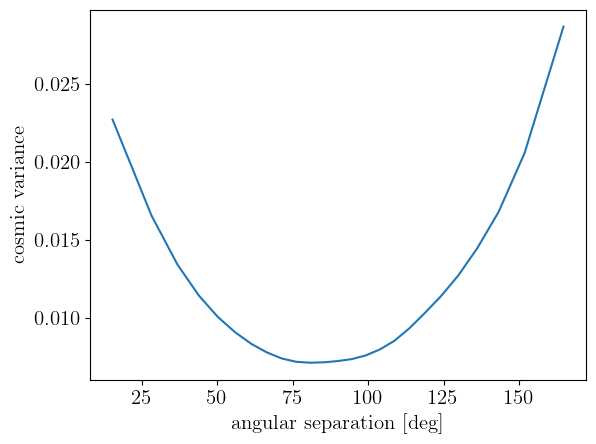

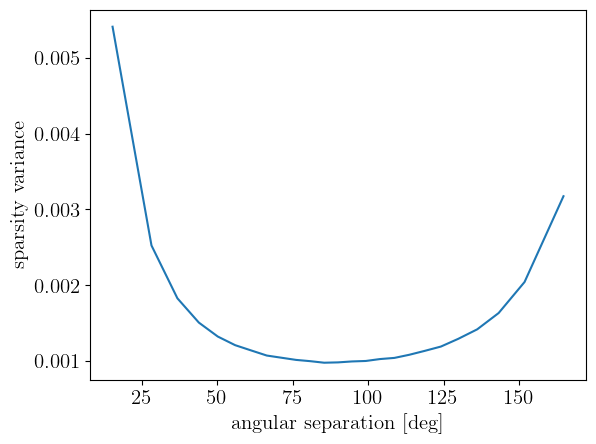

In [32]:
CVar_num = np.diag(CCov_num)
plt.plot(thetas * 180 / np.pi, CVar_num)
plt.xlabel("angular separation [deg]")
plt.ylabel("cosmic variance")
plt.show()

SVar_num = np.diag(SCov_num)
plt.plot(thetas * 180 / np.pi, SVar_num)
plt.xlabel("angular separation [deg]")
plt.ylabel("sparsity variance")
plt.show()

### Theoretical estimate

In [33]:
def monte_carlo_integrate(func, bounds, num_samples=1e6, confidence=0.95):
    
    """
    Monte Carlo integration over a given domain with error estimation.
    Parameters:
    - func (callable): The function to integrate. NB it needs to accept an array as input
                       for integration over multiple dimensions.
    - bounds (list of tuples): Integration bounds [(a1, b1), (a2, b2), ...].
                                For 1D, use [(a, b)].
    - num_samples (int): Number of random samples to use (10^6 gives good result, but with largish errors)
    - confidence (float): Confidence level for the error estimate (default is 0.95) (this is something ChatGPT
                             recommended when I was figuring out how to estimate the error)
    Returns:
    - tuple: (float, float) Estimated value of the integral and its error.
    """

    rng = np.random.default_rng()
        
    # Determine the dimensionality and the volume of the integration domain
    dim = len(bounds)
    volumes = [b - a for a, b in bounds]
    total_volume = np.prod(volumes)
    
    # Generate random samples within the bounds
    samples = np.array([rng.uniform(low=a, high=b, size=num_samples) for a, b in bounds])
    
    # Evaluate the function at the random sample points
    values = func(samples)
    
    # Compute the Monte Carlo estimate of the integral
    integral = total_volume * np.mean(values)
    
    # Estimate the standard error
    variance = np.var(values, ddof=1)  # Sample variance
    std_error = total_volume * np.sqrt(variance / num_samples)
    
    # Compute the confidence interval using the normal distribution
    z = norm.ppf(1 - (1 - confidence) / 2)  # z-score for the confidence level
    error = z * std_error
    
    #if error/integral > 0.1:
    #    print("WARNING: integration error = " + 100 * error/integral + "%")
        
    return integral, error

In [34]:
def generate_CCov(number_bins=25):
    """
    Computes the theoretical cosmic covariance for a certain
    binning scheme.
    """

    Dmu = 2 / 25 # bin size in cosine space (mu)
    mus = [max(1 - a * Dmu, -1) for a in range(number_bins+1)] # limits of the bins

    def integrand(variables):

        mu3, mu2, mu34, phi2, phi34 = variables

        nu3 = (1 - mu3**2)**0.5 # sin(theta3)
        nu2 = (1 - mu2**2)**0.5
        nu34 = (1 - mu34**2)**0.5

        mu24 = (nu2 * np.cos(phi2) * (mu3 * nu34 * np.sin(phi34) + nu3 * mu34)
                + nu2 * np.sin(phi2) * nu3 * np.sin(phi34)
                + mu2 * (- nu3 * nu34 * np.sin(phi34) + mu3 * mu34)
               )
        mu24[mu24>1] = 1
        mu24[mu24<-1] = -1
        
        theta3 = np.arccos(mu3)
        theta24 = np.arccos(mu24)
        
        return xi_model(theta3) * xi_model(theta24)

    CCov = np.zeros((number_bins, number_bins))
    
    for a in range(number_bins):
        for b in range(a, number_bins):
            
            ranges = [(-1, 1), (mus[a+1], mus[a]), (mus[b+1], mus[b]), (0, 2*np.pi), (0, 2*np.pi)]
            integral, err = monte_carlo_integrate(integrand, ranges, num_samples=int(1e6), confidence=0.95)
            prefactor = 2 / (2 * (2 * np.pi)**2 * (mus[a] - mus[a+1]) * (mus[b] - mus[b+1]))
            integral *= prefactor
            #integral, err = nquad(integrand, ranges)
            CCov[a, b] = integral
            CCov[b, a] = integral

    return CCov

In [35]:
CCov_th = generate_CCov(number_bins=25)

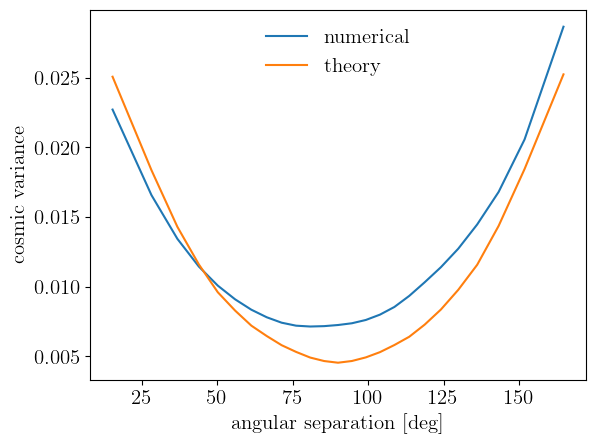

In [36]:
CVar_th = np.diag(CCov_th)
plt.plot(thetas * 180 / np.pi, CVar_num, label='numerical')
plt.plot(thetas * 180 / np.pi, CVar_th, label='theory')
plt.xlabel("angular separation [deg]")
plt.ylabel("cosmic variance")
plt.legend(frameon=False)
plt.show()

In [37]:
def generate_SCov(N=500, number_bins=25):
    """
    Computes the theoretical sparsity covariance for a certain
    binning scheme.
    """

    Dmu = 2 / 25 # bin size in cosine space (mu)
    mus = [max(1 - a * Dmu, -1) for a in range(number_bins+1)] # limits of the bins

    
    def integrand1124_1234(variables):

        mu2, mu4, phi4 = variables

        nu2 = (1 - mu2**2)**0.5
        nu4 = (1 - mu4**2)**0.5
    
        mu24 = nu2 * nu4 * np.cos(phi4) + mu2 * mu4
        mu24[mu24>1] = 1
        mu24[mu24<-1] = -1

        theta2 = np.arccos(mu2)
        theta4 = np.arccos(mu4)
        theta24 = np.arccos(mu24)

        return xi_model(0) * xi_model(theta24) + xi_model(theta2) * xi_model(theta4)
        

    def integrand1324(variables):

        mu3, mu2, mu34, phi2, phi34 = variables

        nu3 = (1 - mu3**2)**0.5 # sin(theta3)
        nu2 = (1 - mu2**2)**0.5
        nu34 = (1 - mu34**2)**0.5

        mu24 = (nu2 * np.cos(phi2) * (mu3 * nu34 * np.sin(phi34) + nu3 * mu34)
                + nu2 * np.sin(phi2) * nu3 * np.sin(phi34)
                + mu2 * (- nu3 * nu34 * np.sin(phi34) + mu3 * mu34)
               )
        mu24[mu24>1] = 1
        mu24[mu24<-1] = -1
        
        theta3 = np.arccos(mu3)
        theta24 = np.arccos(mu24)
        
        return xi_model(theta3) * xi_model(theta24)


    def integrand12(variables):

        mu2 = variables
        theta2 = np.arccos(mu2)
        
        return xi_model(theta2)
    
    
    def integrand12_sq(variables):

        mu2 = variables
        theta2 = np.arccos(mu2)
        
        return xi_model(theta2)**2

    
    SCov = np.zeros((number_bins, number_bins))
    
    for a in range(number_bins):
        
        for b in range(a, number_bins):

            ranges = [(mus[a+1], mus[a]), (mus[b+1], mus[b]), (0, 2*np.pi)]
            integral1124_1234, err = monte_carlo_integrate(integrand1124_1234, ranges,
                                                           num_samples=int(1e6), confidence=0.95)
            norm = (mus[a+1] - mus[a]) * (mus[b+1] - mus[b]) * (2 * np.pi)
            integral1124_1234 /= norm

            ranges = [(-1, 1), (mus[a+1], mus[a]), (mus[b+1], mus[b]), (0, 2*np.pi), (0, 2*np.pi)]
            integral1324, err = monte_carlo_integrate(integrand1324, ranges,
                                                      num_samples=int(1e6), confidence=0.95)
            norm = 2 * (mus[a+1] - mus[a]) * (mus[b+1] - mus[b]) * (2 * np.pi)**2
            integral1324 /= norm

            SCov[a, b] = (4 / N) * (integral1124_1234 - 2 * integral1324)
            SCov[b, a] = SCov[a, b]

            if b==a:

                ranges = [(mus[a+1], mus[a])]
                
                integral12_sq, err = monte_carlo_integrate(integrand12_sq, ranges, num_samples=int(1e5), confidence=0.95)
                integral12_sq /= (mus[a+1] - mus[a])
                
                integral12, err = monte_carlo_integrate(integrand12, ranges, num_samples=int(1e5), confidence=0.95)
                integral12 /= (mus[a+1] - mus[a])

                Omega   = 4 * np.pi
                Omega_a = 2 * np.pi * Dmu
                prefactor = 2 * Omega / Omega_a / N**2

                SCov[a, a] += prefactor * (xi_model(0)**2
                                           + 2 * integral12_sq
                                           - integral12**2
                                           - 2 * integral1324)

    return SCov

In [38]:
SCov_th = generate_SCov(N=500, number_bins=25)

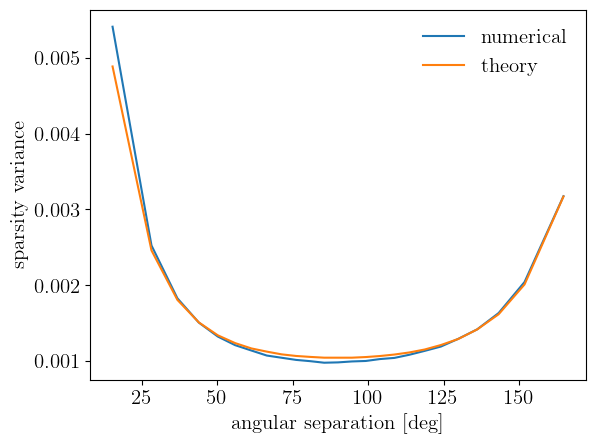

In [39]:
SVar_th = np.diag(SCov_th)
plt.plot(thetas * 180 / np.pi, SVar_num, label='numerical')
plt.plot(thetas * 180 / np.pi, SVar_th, label='theory')
plt.xlabel("angular separation [deg]")
plt.ylabel("sparsity variance")
plt.legend(frameon=False)
plt.show()

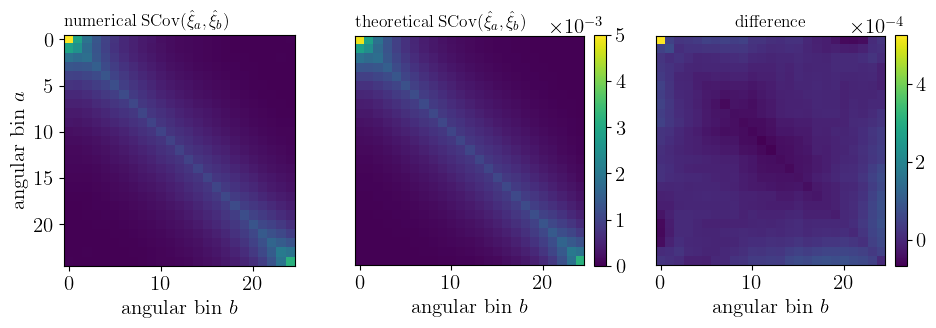

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))

ax = axes[0]
ax.imshow(SCov_num, interpolation='none', vmin=0, vmax=5e-3)
title = r'numerical $\mathrm{SCov}(\hat{\xi}_a, \hat{\xi}_b)$'
ax.set_title(title, fontsize='small', loc='left')
ax.set_xlabel(r'angular bin $b$')
ax.set_ylabel(r'angular bin $a$')

ax = axes[1]
im = ax.imshow(SCov_th, interpolation='none', vmin=0, vmax=5e-3)
title = r'theoretical $\mathrm{SCov}(\hat{\xi}_a, \hat{\xi}_b)$'
ax.set_title(title, fontsize='small', loc='left')
ax.set_xlabel(r'angular bin $b$')
ax.set_yticks([])
#ax.set_ylabel(r'angular bin $a$')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.formatter.set_powerlimits((0, 0))

ax = axes[2]
im = ax.imshow(SCov_num - SCov_th, interpolation='none')
title = r'difference'
ax.set_title(title, fontsize='small')
ax.set_xlabel(r'angular bin $b$')
ax.set_yticks([])
#ax.set_ylabel(r'angular bin $a$')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.formatter.set_powerlimits((0, 0))

plt.savefig(path+'test_sparsity_covariance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Estimating $\xi_+(0)$ for shear<a class="anchor" id="sigma_shear"></a>
[Back to contents](#contents)

## 2.A Compute $C_\ell^\gamma$ with CAMB<a class="anchor" id="C_ell"></a>
[Back to contents](#contents)

In [6]:
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
import sys, platform, os
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/camb


In [7]:
# CAMB parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.37, ombh2=0.0223, omch2=0.1198)
pars.InitPower.set_params(ns=0.965)

class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [8]:
# Generate spectra up to small scales (this is the longest step)
zmax = 100
kmax = 5e2 #(inverse Mpc)
extrap_kmax = 1e10
Weyl_power_spectra = camb.get_matter_power_interpolator(pars, zmax=zmax, kmax=kmax, zs=None,
hubble_units=False, k_hunit=False, var1=model.Transfer_Weyl, var2=model.Transfer_Weyl, extrap_kmax=extrap_kmax)

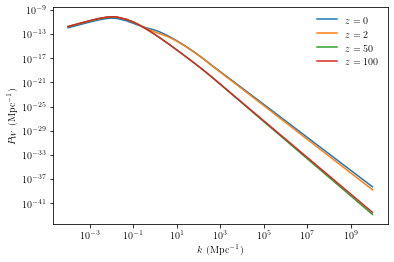

In [9]:
k = np.logspace(-4, 10, 100)

zplot = [0, 2, 50, 100]
for z in zplot:
    plt.loglog(k, Weyl_power_spectra.P(z,k))
#plt.xlim([1e-4,1e4])
plt.xlabel('$k$ (Mpc$^{-1}$)')
plt.ylabel('$P_W$ (Mpc$^{-1}$)')
plt.legend(['$z=%s$'%z for z in zplot], frameon=False);

In [10]:
def get_cl(z, lmax, nl):
    """
    This function generates Cls for convergence and shear
    It takes as argument the redshift z of the source, and
    the maximum multipole lmax.
    nl is the number of values to be computed.
    """
    
    nz = 100 #number of elements for discrete integral along the los
    
    # Conformal distances and redshifts
    results= camb.get_background(pars)
    chi = results.conformal_time(0) - results.conformal_time(z)
    chis = np.linspace(0, chi, nz)
    zs = results.redshift_at_comoving_radial_distance(chis)
    
    # Array of delta_chi, and drop first and last points where things go singular
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    
    # Lensing kernel (spatially flat universe)
    kernel = ((chi-chis)/(chis**2*chi))**2
    
    # Integration over chi
    lmin = 1
    ls = np.logspace(np.log10(lmin), np.log10(lmax), nl)
    integral = np.zeros(ls.shape)
    w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
    
    # Check that lmax is not too big
    if lmax > extrap_kmax * chis[-1]:
        print("""Warning: lmax is too large given the range of extrapolation given to CAMB
for the power spectrum. The results cannot be trusted.""")
    
    for i, l in enumerate(ls):
        k = (l + 0.5)/chis
        w[:] = 1
        w[k<1e-4] = 0
        w[k>=extrap_kmax] = 0
        integral[i] = np.dot(dchis, w * Weyl_power_spectra.P(zs, k, grid=False) * kernel / k**4)
        # The k**4 comes from the convention of CAMB for the Weyl potential, which is k**2 times
        # the actual gravitational potential.

    cl = integral * (ls * (ls+1))**2
    
    return ls, cl

In [11]:
lmax = 1e8
nl = 600
zplot = [1, 2, 50, 100] # source redshift
cl = []

for z in zplot:
    result = get_cl(z, lmax, nl)
    cl.append(result[1])
    
ls = result[0]

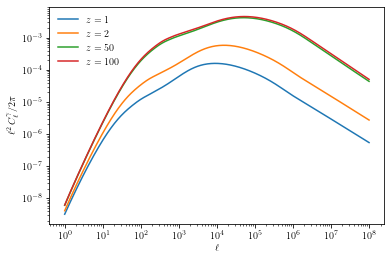

In [12]:
for i, z in enumerate(zplot):
    plt.loglog(ls, ls**2*cl[i]/(2*np.pi), label="$z = %s$"%z)
plt.ylabel('$\ell^2\,C_\ell^\gamma/2\pi$')
plt.xlabel('$\ell$')
#plt.xlim([1e2,1e6])
#plt.ylim([1e-7,4e-5])
plt.legend(frameon=False);

## 2.B Variance of shear<a class="anchor" id="sigma_gamma"></a>
[Back to contents](#contents)

In [13]:
def variance_shear(z, lmax=1e7):
    """
    This function computes the variance of the weak-lensing shear
    for a source at a redshift z. Integration is performed until lmax.
    """
    
    # Compute the power spectrum
    nl = 1000
    ls, cl_kappa = get_cl(z, lmax, nl)
    
    # Integration over l. Attention, the ls are homogeneously distributed in
    # log space, so the natural intregration variable is log10(l) rather than l
    logls = np.log10(ls)
    dlogls = (logls[2:] - logls[:-2]) / 2
    integrand = np.log(10) * ls**2 * cl_kappa / (2 * np.pi)
    integrand = integrand[1:-1]
    
    sigma2 = np.dot(dlogls, integrand)
    
    return sigma2

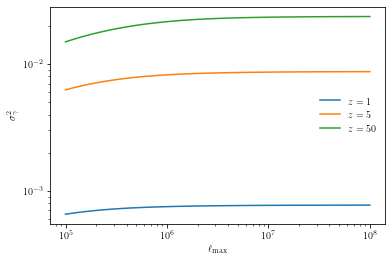

In [14]:
# Check convergence with large lmax
lmaxs = np.logspace(5, 8, 100)

for z in [1, 5, 50]:
    sigma2 = [variance_shear(z, lmax) for lmax in lmaxs]
    plt.loglog(lmaxs, sigma2, label=r'$z={}$'+str(z))
    
#plt.ylim([0, 3e-3])
plt.ylabel(r'$\sigma^2_\gamma$')
plt.xlabel(r'$\ell_{\rm max}$')
plt.legend(frameon=False)
plt.show();

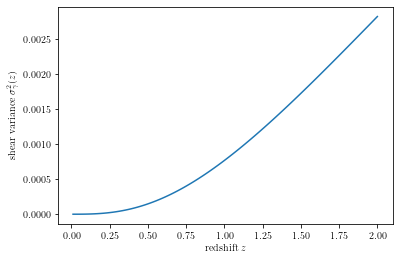

In [15]:
lmax = 1e7
zs = np.linspace(0.01, 2, 100)
sigma2 = np.array([variance_shear(z, lmax) for z in zs])

plt.plot(zs, sigma2)
plt.xlabel("redshift $z$")
plt.ylabel("shear variance $\sigma_\gamma^2(z)$")
plt.show();

## 2.C Fitting function<a class="anchor" id="fitting_function"></a>
[Back to contents](#contents)

[1.17823719 1.51856246 0.03513744]


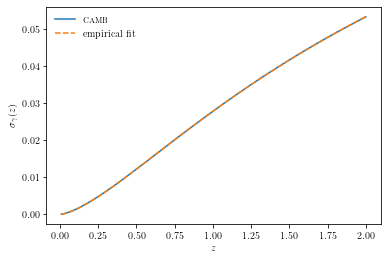

In [16]:
def sigma_fit(z, a, b, c):
    sigma = (1 + a * z**b)**c - 1
    return sigma

sigma = sigma2**0.5
popt, pcov = curve_fit(sigma_fit, zs, sigma)
print(popt)

plt.plot(zs, sigma, label=r'{\sc camb}')
plt.plot(zs, sigma_fit(zs, *popt), '--', label='empirical fit')
plt.ylabel(r'$\sigma_\gamma(z)$')
plt.xlabel(r'$z$')
plt.legend(frameon=False)
plt.show();

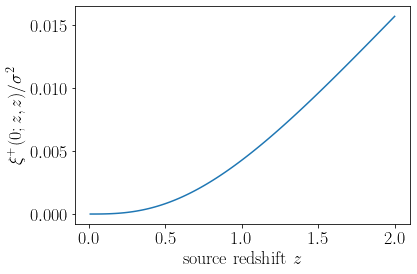

In [19]:
matplotlib.rcParams.update({'font.size': 18})
plt.plot(zs, sigma2/(2*0.3**2))
plt.ylabel(r'$\xi^+(0;z, z)/\sigma^2$')
plt.xlabel(r'source redshift $z$')
plt.savefig(path+"variance_shear_ellipticity.pdf", bbox_inches='tight')
plt.show();

## 2.D Application to KiDS1000<a class="anchor" id="KiDS1000"></a>
[Back to contents](#contents)

In [20]:
# Import the photo-z distribution of KiDS1000

path_zdist = "data/K1000_redshift_distribution/"

Nzbin = 5
zdists = []

for b in range(Nzbin):
    filename = path_zdist + 'K1000_photoz_' + str(b+1) + '.asc'
    zdist = np.loadtxt(filename)
    zdists.append(zdist)

In [21]:
# check normalisation
for b in range(Nzbin):
    print(np.sum(zdists[b][:,1]))

0.9932251015620409
0.9986899382099684
0.9991112330831369
0.9995096501558105
1.0


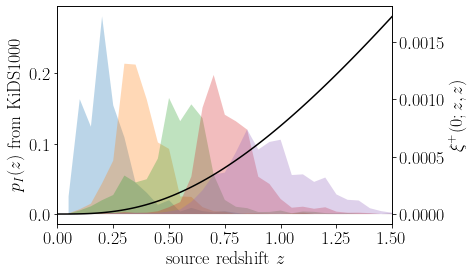

In [22]:
# Plot xi+(0, z, z) with the redshift distribution 

matplotlib.rcParams.update({'font.size': 18})

fig = matplotlib.figure.Figure()

zs = np.linspace(0, 1.5, 100)
xiplus0 = sigma_fit(zs, *popt)**2

# KiDS redshift distributions
ax1 = fig.add_subplot()
for zdist in zdists:
    ax1.fill_between(zdist[:, 0], zdist[:, 1], alpha=0.3)
ax1.set_xlabel(r'source redshift $z$')
ax1.set_ylabel(r'$p_I(z)$ from KiDS1000')
ax1.set_xlim([0, 1.5])

# xi+0/sigma2
ax2 = ax1.twinx()
ax2.plot(zs, xiplus0, 'k')
ax2.set_ylabel(r'$\xi^+(0;z, z)$')

fig.savefig(path+"mean_square_shear.pdf", bbox_inches='tight')
display(fig)

Mean square of shear, apparent ellipticity, intrinsic ellipticity

In [23]:
# Ellipticity dispersion in each redshift bin of KIDS1000 [survey specs]
ellipticity_dispersion = np.array([0.270, 0.258, 0.273, 0.254, 0.270])

# Mean square of apparent ellipticity: <|e|^2> = 2 * ellipticity_dispersion^2
ellipticity_msq = 2 * ellipticity_dispersion**2

In [24]:
# Mean square of shear <|gamma|^2> = xi+(0) in each bin

shear_msq = []

for b in range(Nzbin):
    
    zdist = zdists[b]
    z = zdist[:, 0]
    p = zdist[:, 1]
    xi0 = np.dot(p, sigma_fit(z, *popt)**2)
    
    shear_msq.append(xi0)

In [25]:
# Mean square of *intrinsic* ellipticity

ellipticity0_msq = ellipticity_msq - shear_msq
ellipticity0_dispersion = np.sqrt(ellipticity0_msq / 2)

In [26]:
print("ellipticity_msq = ", ellipticity_msq)
print("shear_msq = ", shear_msq)
print("ellipticity0_msq = ", ellipticity0_msq)
print("-----")
print("ellipticity_dispersion = ", ellipticity_dispersion)
print("ellipticity0_dispersion = ", ellipticity0_dispersion)

ellipticity_msq =  [0.1458   0.133128 0.149058 0.129032 0.1458  ]
shear_msq =  [4.00646238359364e-05, 9.064750351189704e-05, 0.00021265459877102967, 0.0004437464667246209, 0.0007369621721108998]
ellipticity0_msq =  [0.14575994 0.13303735 0.14884535 0.12858825 0.14506304]
-----
ellipticity_dispersion =  [0.27  0.258 0.273 0.254 0.27 ]
ellipticity0_dispersion =  [0.2699629  0.25791215 0.27280519 0.25356287 0.26931676]


In [187]:
print('<gamma^2>/<eps0^2>')
print('---')
for i, r in enumerate(shear_msq/ellipticity0_msq):
    print('bin {}: {} %'.format(i+1, 100*r))

<gamma^2>/<eps0^2>
---
bin 1: 0.027486718989371967 %
bin 2: 0.06813688171845568 %
bin 3: 0.14286949867178972 %
bin 4: 0.34509098189889525 %
bin 5: 0.5080289115310496 %


#### Covariance matrix

In [77]:
# Load the output files produced with OneCov

# Cov produced with the observed ellipticity dispersion (ellipticity_dispersion above)
file_CNSCov = "data/output_OneCov/KiDS1000_like/CNSCov/covariance_list.dat" 

# Cov produced with the intrinsic ellipticity dispersion (ellipticity0_dispersion above)
file_CNCov  = "data/output_OneCov/KiDS1000_like/CNCov/covariance_list.dat"

data_CNSCov = np.array(np.loadtxt(file_CNSCov, usecols = np.arange(1,15)))
data_CNCov  = np.array(np.loadtxt(file_CNCov, usecols = np.arange(1,15)))

In [50]:
def get_covariance(data_onecov, n_tomo=5, n_data=9, component="all"):
    """
    This function extracts the covariance matrix, or pieces of it, from the file
    covariance_list.dat produced by OneCov.
    
    Many thanks to Robert Reischke for providing me with the base of this piece of code!
    """
    
    if component == "ssc":
        index = 13
    if component == "ng":
        index = 12
    if component == "sn":
        index = 11
    if component == "mix":
        index = 10
    if component == "g":
        index = 9
    if component == "all":
        index = 8
        
    flat_idx = 0
    array_covariance = np.zeros((2,2,n_data,n_data,1,1,n_tomo,n_tomo,n_tomo,n_tomo))
    
    for i_obs in range(2):
        for j_obs in range(i_obs, 2):
            for i_theta in range(n_data):
                for j_theta in range(n_data):
                    for i_tomo in range(n_tomo):
                        for j_tomo in range(i_tomo, n_tomo):
                            for k_tomo in range(n_tomo):
                                for l_tomo in range(k_tomo, n_tomo):
                            
                                    cov = data_onecov[flat_idx, index]
                                    
                                    # fill in using symmetries of tomographic bins
                                    array_covariance[i_obs,j_obs,i_theta,j_theta,0,0,i_tomo,j_tomo,k_tomo,l_tomo] = cov
                                    array_covariance[i_obs,j_obs,i_theta,j_theta,0,0,i_tomo,j_tomo,l_tomo,k_tomo] = cov
                                    array_covariance[i_obs,j_obs,i_theta,j_theta,0,0,j_tomo,i_tomo,k_tomo,l_tomo] = cov
                                    array_covariance[i_obs,j_obs,i_theta,j_theta,0,0,j_tomo,i_tomo,l_tomo,k_tomo] = cov
                                    
                                    # fill in using symmetry of observables
                                    array_covariance[j_obs,i_obs,j_theta,i_theta,0,0,k_tomo,l_tomo,i_tomo,j_tomo] = cov
                                    array_covariance[j_obs,i_obs,j_theta,i_theta,0,0,l_tomo,k_tomo,i_tomo,j_tomo] = cov
                                    array_covariance[j_obs,i_obs,j_theta,i_theta,0,0,l_tomo,k_tomo,j_tomo,i_tomo] = cov
                                    array_covariance[j_obs,i_obs,j_theta,i_theta,0,0,l_tomo,k_tomo,j_tomo,i_tomo] = cov
                                    
                                    flat_idx += 1
    #print("flat_idx = ", flat_idx)
                            
    data_size = int(2 * n_tomo*(n_tomo + 1)/2 * n_data)
    
    i = 0
    covariance = np.zeros((data_size, data_size))
    
    for i_obs in range(2):
        for i_tomo in range(n_tomo):
            for j_tomo in range(i_tomo, n_tomo):
                for i_sample in range(1):
                    for i_theta in range(n_data):
                        j = 0
                        for j_obs in range(2):
                            for k_tomo in range(n_tomo):
                                for l_tomo in range(k_tomo, n_tomo):
                                    for j_sample in range(1):
                                        for j_theta in range(n_data):
                                            covariance[i,j] = array_covariance[i_obs,j_obs,i_theta,j_theta,i_sample,j_sample,i_tomo,j_tomo,k_tomo,l_tomo]
                                            j += 1
                        i += 1
                    
    return covariance

In [78]:
# Full covariance matrix
Cov_KiDS1000   = get_covariance(data_CNSCov, component="all")

# Covariance matrix without sparsity contribution
CNCov_KiDS1000 = get_covariance(data_CNCov, component="all")

In [86]:
# Check that the sparsity contribution does not affect cosmic covariance

CCov_KiDS1000_w_sparsity  = get_covariance(data_CNSCov, component="g")
CCov_KiDS1000_wo_sparsity = get_covariance(data_CNCov, component="g")

test = CCov_KiDS1000_w_sparsity - CCov_KiDS1000_wo_sparsity

np.all(test == 0)

True

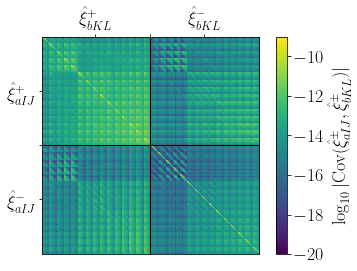

In [148]:
# Plot of the full covariance matrix in log space

matrix = np.log10(abs(Cov_KiDS1000))
plt.imshow(matrix, interpolation='none', vmax=-9, vmin=-20)

plt.axhline(y=len(matrix)/2-1, color='black', linewidth=1, ls = "-")
plt.axvline(x=len(matrix)/2-1, color='black', linewidth=1, ls = "-")

# column labels
xticks = [len(matrix)/4-1, len(matrix)/2-1, 3*len(matrix)/4-1]
xlabels = [r"$\hat{\xi}^+_{bKL}$", '', r"$\hat{\xi}^-_{bKL}$"]
plt.xticks(xticks, xlabels)

# row labels
yticks = [len(matrix)/4-1, len(matrix)/2-1, 3*len(matrix)/4-1]
ylabels = [r"$\hat{\xi}^+_{aIJ}$", '', r"$\hat{\xi}^-_{aIJ}$"]

plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)

plt.colorbar(label=r"$\log_{10}|\mathrm{Cov}(\hat{\xi}^\pm_{aIJ}, \hat{\xi}^\pm_{bKL})|$")

plt.savefig(path+'Cov_KiDS1000.png', dpi=1000, bbox_inches='tight', pad_inches=0.1)
plt.show()

<ipython-input-146-dd68a7918bf8>:9: RuntimeWarning: divide by zero encountered in log10
  matrix = np.log10(abs(SCov_KiDS1000)) - np.log10(abs(Cov_KiDS1000))


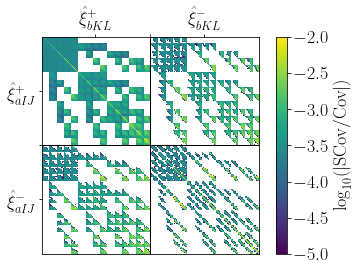

In [146]:
# Plot of the relative contribution of sparsity

SCov_KiDS1000 = Cov_KiDS1000 - CNCov_KiDS1000

# replace zero values for the plot
#eps = 1e-20
#SCov_KiDS1000[SCov_KiDS1000==0.] = eps

matrix = np.log10(abs(SCov_KiDS1000)) - np.log10(abs(Cov_KiDS1000))
#matrix = SCov_KiDS1000

plt.imshow(matrix, interpolation='none', vmax=-2, vmin=-5)

plt.axhline(y=len(matrix)/2-1, color='black', linewidth=1, ls = "-")
plt.axvline(x=len(matrix)/2-1, color='black', linewidth=1, ls = "-")

# column labels
xticks = [len(matrix)/4-1, len(matrix)/2-1, 3*len(matrix)/4-1]
xlabels = [r"$\hat{\xi}^+_{bKL}$", '', r"$\hat{\xi}^-_{bKL}$"]
plt.xticks(xticks, xlabels)

# row labels
yticks = [len(matrix)/4-1, len(matrix)/2-1, 3*len(matrix)/4-1]
ylabels = [r"$\hat{\xi}^+_{aIJ}$", '', r"$\hat{\xi}^-_{aIJ}$"]

plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)

plt.colorbar(label=r'$\log_{10}(|\mathrm{SCov}/\mathrm{Cov}|)$')

plt.savefig(path+'SCov_KiDS1000.png', dpi=1000, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [149]:
# Sparsity contribution to the variance (diagonal part of the covariance)

SVar_KiDS1000 = np.diag(SCov_KiDS1000)
Var_KiDS1000  = np.diag(Cov_KiDS1000)

# Split ++ and --
end_plus = len(Var_KiDS1000)//2
SVar_plus_KiDS1000  = SVar_KiDS1000[:end_plus]
Var_plus_KiDS1000   = Var_KiDS1000[:end_plus]
SVar_minus_KiDS1000 = SVar_KiDS1000[end_plus:]
Var_minus_KiDS1000  = Var_KiDS1000[end_plus:]

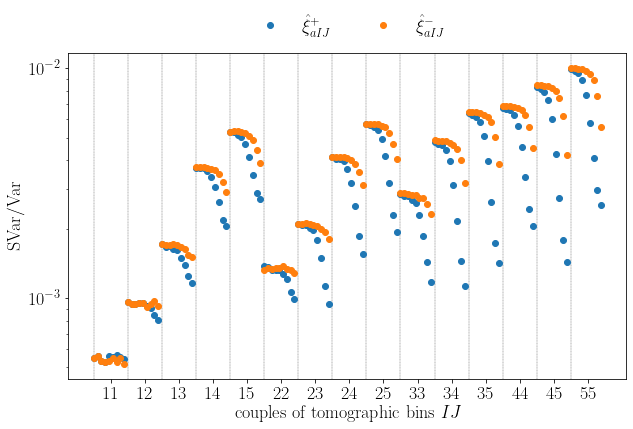

In [182]:
n_tomo  = 5
n_theta = 9

xticks  = []
xlabels = []

i_flat = 0

plt.subplots(figsize=(10, 6))

for i_tomo in range(n_tomo):
    for j_tomo in range(i_tomo, n_tomo):
        
        plt.axvline(x=i_flat, color='black', linewidth=0.3, ls = "--")
        xticks.append(i_flat+4.5)
        xlabels.append(str(i_tomo+1)+str(j_tomo+1))
        
        for _ in range(n_theta):
            i_flat += 1

plt.semilogy(SVar_plus_KiDS1000/Var_plus_KiDS1000, 'o', label=r'$\hat{\xi}^+_{aIJ}$')
plt.semilogy(SVar_minus_KiDS1000/Var_minus_KiDS1000, 'o', label=r'$\hat{\xi}^-_{aIJ}$')

plt.xticks(xticks, xlabels)
plt.xlabel(r'couples of tomographic bins $IJ$')
plt.ylabel(r'$\mathrm{SVar}/\mathrm{Var}$')
plt.legend(frameon=False, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 1))

plt.show()